
## Grading Criteria

**Maximum Score: 10 points**

1. **Step #1: Implementation of Attention Mechanisms (4 points)**  
   - 2 points for implementing the `additive` attention mechanism correctly.
   - 2 points for implementing the `multiplicative` attention mechanism correctly.

2. **Step #2: BERT-based Text Classification Task (4 points)**  
   - 2 points for setting up the BERT model correctly for classification.
   - 2 points for evaluating the model performance accurately.

3. **Code Quality and Comments (2 points)**  
   - 1 point for code clarity and logical structuring of functions and classes.
   - 1 point for detailed comments explaining each part of the code.

**Total: 10 points**  
Each section will be reviewed to ensure that all requirements are met and that the code is efficient and well-documented. Pay attention to using proper variable names and providing comments that describe the purpose of each function and major code sections.


## Attention & BERT

For this homework assignment, your goal is to delve into the Attention mechanism (implementing several of its variants) and revisit the text classification task, this time solving it with BERT.


In [2]:
import os
import random

import numpy as np
import pandas as pd

from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
from IPython.display import clear_output 
# Display inline matplotlib plots
# %matplotlib inline

### Step #1. Implementation of Attention

In this task, please implement the Attention mechanism, specifically several methods for calculating attention scores. While this mechanism is already implemented in popular frameworks, you'll implement it using `numpy` to gain a better understanding.

Your task in this part: implement `additive` and `multiplicative` variants of Attention. For your convenience (and as an example), the `dot product` attention (based on scalar product) is already implemented.

Detailed descriptions of these types of Attention are available in the lecture slides.

Text(0.5, 1.0, 'Decoder state')

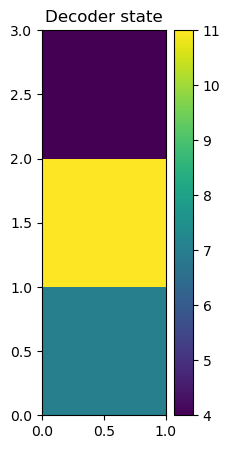

In [3]:
decoder_hidden_state = np.array([7, 11, 4]).astype(float)[:, None]

plt.figure(figsize=(2, 5))
plt.pcolormesh(decoder_hidden_state)
plt.colorbar()
plt.title("Decoder state")

Dot product attention (example implementation)

Let's consider a single encoder state – a vector with dimensions `(n_hidden, 1)`, where `n_hidden = 3`:


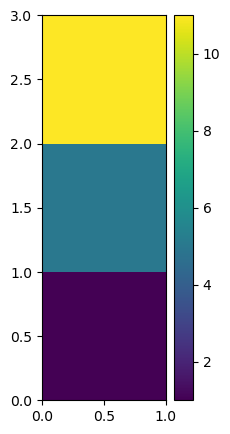

In [4]:
single_encoder_hidden_state = np.array([1, 5, 11]).astype(float)[:, None]

plt.figure(figsize=(2, 5))
plt.pcolormesh(single_encoder_hidden_state)
plt.colorbar()

The attention score between these encoder and decoder states is simply calculated as a dot product:

In [5]:
np.dot(decoder_hidden_state.T, single_encoder_hidden_state)

array([[106.]])

In the general case, there are, of course, multiple encoder states. Attention scores are computed with each encoder state:

In [6]:
encoder_hidden_states = (
    np.array([[1, 5, 11], [7, 4, 1], [8, 12, 2], [-9, 0, 1]]).astype(float).T
)

encoder_hidden_states

array([[ 1.,  7.,  8., -9.],
       [ 5.,  4., 12.,  0.],
       [11.,  1.,  2.,  1.]])

Then, to calculate the dot products between a single decoder state and all encoder states, we can use the following function (which is essentially just matrix multiplication and type conversion):


In [7]:
def dot_product_attention_score(decoder_hidden_state, encoder_hidden_states):
    """
    decoder_hidden_state: np.array of shape (n_features, 1)
    encoder_hidden_states: np.array of shape (n_features, n_states)

    return: np.array of shape (1, n_states)
        Array with dot product attention scores
    """
    attention_scores = np.dot(decoder_hidden_state.T, encoder_hidden_states)
    return attention_scores

In [8]:
dot_product_attention_score(decoder_hidden_state, encoder_hidden_states)

array([[106.,  97., 196., -59.]])

To calculate the "weights," we need Softmax:

In [9]:
def softmax(vector):
    """
    vector: np.array of shape (n, m)

    return: np.array of shape (n, m)
        Matrix where softmax is computed for every row independently
    """
    nice_vector = vector - vector.max()
    exp_vector = np.exp(nice_vector)
    exp_denominator = np.sum(exp_vector, axis=1)[:, np.newaxis]
    softmax_ = exp_vector / exp_denominator
    return softmax_

In [10]:
weights_vector = softmax(
    dot_product_attention_score(decoder_hidden_state, encoder_hidden_states)
)

weights_vector

array([[8.19401262e-040, 1.01122149e-043, 1.00000000e+000,
        1.79848622e-111]])

Finally, we'll use these weights and compute the final vector, as described for dot product attention.


[[ 8.]
 [12.]
 [ 2.]]


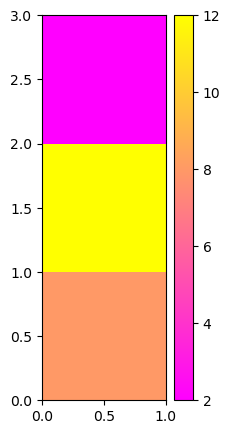

In [11]:
attention_vector = weights_vector.dot(encoder_hidden_states.T).T
print(attention_vector)

plt.figure(figsize=(2, 5))
plt.pcolormesh(attention_vector, cmap="spring")
plt.colorbar()

This vector accumulates information from all encoder states, weighted based on proximity to the given decoder state. Let's implement all the above transformations in a single function:

In [12]:
def dot_product_attention(decoder_hidden_state, encoder_hidden_states):
    """
    decoder_hidden_state: np.array of shape (n_features, 1)
    encoder_hidden_states: np.array of shape (n_features, n_states)

    return: np.array of shape (n_features, 1)
        Final attention vector
    """
    softmax_vector = softmax(
        dot_product_attention_score(decoder_hidden_state, encoder_hidden_states)
    )
    attention_vector = softmax_vector.dot(encoder_hidden_states.T).T
    return attention_vector

In [13]:
assert (
    attention_vector
    == dot_product_attention(decoder_hidden_state, encoder_hidden_states)
).all()

Multiplicative attention. Your current task: implement multiplicative attention.

$$
e_i = \mathbf{s}^TW_{mult}\mathbf{h}_i
$$

The weight matrix `W_mult` is given below. It should be noted that multiplicative attention allows working with encoder and decoder states of different dimensions, so the encoder states will be updated:


In [14]:
encoder_hidden_states_complex = (
    np.array([[1, 5, 11, 4, -4], [7, 4, 1, 2, 2], [8, 12, 2, 11, 5], [-9, 0, 1, 8, 12]])
    .astype(float)
    .T
)

W_mult = np.array(
    [
        [-0.78, -0.97, -1.09, -1.79, 0.24],
        [0.04, -0.27, -0.98, -0.49, 0.52],
        [1.08, 0.91, -0.99, 2.04, -0.15],
    ]
)

Implement the attention calculation according to the formulas and create the final function `multiplicative_attention`:

Additive attention. Now you need to implement additive attention.

$$
e_i = \mathbf{v}^T \text{tanh} (W_{add-enc} \mathbf{h}_i + W_{add-dec} \mathbf{s})
$$

The weight matrices `W_add_enc` and `W_add_dec` are provided below, as well as the weight vector `v_add`. For activation calculation, you can use `np.tanh`.

In [17]:
v_add = np.array([[-0.35, -0.58, 0.07, 1.39, -0.79, -1.78, -0.35]]).T

W_add_enc = np.array(
    [
        [-1.34, -0.1, -0.38, 0.12, -0.34],
        [-1.0, 1.28, 0.49, -0.41, -0.32],
        [-0.39, -1.38, 1.26, 1.21, 0.15],
        [-0.18, 0.04, 1.36, -1.18, -0.53],
        [-0.23, 0.96, 1.02, 0.39, -1.26],
        [-1.27, 0.89, -0.85, -0.01, -1.19],
        [0.46, -0.12, -0.86, -0.93, -0.4],
    ]
)

W_add_dec = np.array(
    [
        [-1.62, -0.02, -0.39],
        [0.43, 0.61, -0.23],
        [-1.5, -0.43, -0.91],
        [-0.14, 0.03, 0.05],
        [0.85, 0.51, 0.63],
        [0.39, -0.42, 1.34],
        [-0.47, -0.31, -1.34],
    ]
)

Implement the attention calculation according to the formulas and create the final function `additive_attention`:

In [ ]:
import numpy as np

def softmax(vector):
    """
    vector: np.array of shape (n, m)

    return: np.array of shape (n, m)
        Matrix where softmax is computed for every row independently
    """
    nice_vector = vector - np.max(vector, axis=1, keepdims=True)
    exp_vector = np.exp(nice_vector)
    exp_denominator = np.sum(exp_vector, axis=1, keepdims=True)
    softmax_ = exp_vector / exp_denominator
    return softmax_

def multiplicative_attention(decoder_hidden_state, encoder_hidden_states, W_mult):
    """
    decoder_hidden_state: np.array of shape (n_features_dec, 1)
    encoder_hidden_states: np.array of shape (n_features_enc, n_states)
    W_mult: np.array of shape (n_features_dec, n_features_enc)

    return: np.array of shape (n_features_enc, 1)
        Final attention vector
    """
    temp = np.dot(decoder_hidden_state.T, W_mult)
    attention_scores = np.dot(temp, encoder_hidden_states)
    weights_vector = softmax(attention_scores)
    attention_vector = np.dot(weights_vector, encoder_hidden_states.T).T
    return attention_vector

def additive_attention(decoder_hidden_state, encoder_hidden_states, v_add, W_add_enc, W_add_dec):
    """
    decoder_hidden_state: np.array of shape (n_features_dec, 1)
    encoder_hidden_states: np.array of shape (n_features_enc, n_states)
    v_add: np.array of shape (n_features_int, 1)
    W_add_enc: np.array of shape (n_features_int, n_features_enc)
    W_add_dec: np.array of shape (n_features_int, n_features_dec)

    return: np.array of shape (n_features_enc, 1)
        Final attention vector
    """
    W_enc_h = np.dot(W_add_enc, encoder_hidden_states) 
    W_dec_s = np.dot(W_add_dec, decoder_hidden_state) 
    pre_activation = W_enc_h + W_dec_s 
    activation = np.tanh(pre_activation) 
    attention_scores = np.dot(v_add.T, activation)
    weights_vector = softmax(attention_scores) 
    attention_vector = np.dot(weights_vector, encoder_hidden_states.T).T
    return attention_vector

Submit the `multiplicative_attention` and `additive_attention` functions in the contest. Don’t forget to import `numpy`!

### Step #2. Text classification using a pretrained language model.

We work with the SST-2 dataset. Split the dataset into train and test sets.

In [19]:
# do not change the code in the block below
# __________start of block__________

!wget https://raw.githubusercontent.com/girafe-ai/ml-course/msu_branch/homeworks/hw08_attention/holdout_texts08.npy
# __________end of block__________

--2024-11-25 21:38:03--  https://raw.githubusercontent.com/girafe-ai/ml-course/msu_branch/homeworks/hw08_attention/holdout_texts08.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8002::154, 2606:50c0:8003::154, 2606:50c0:8000::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8002::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 45416 (44K) [application/octet-stream]
Saving to: ‘holdout_texts08.npy’

holdout_texts08.npy 100%[===================>]  44.35K   158KB/s    in 0.3s    

2024-11-25 21:38:05 (158 KB/s) - ‘holdout_texts08.npy’ saved [45416/45416]



In [20]:
# do not change the code in the block below
# __________start of block__________
df = pd.read_csv(
    "https://github.com/clairett/pytorch-sentiment-classification/raw/master/data/SST2/train.tsv",
    delimiter="\t",
    header=None,
)
texts_train = df[0].values[:5000]
y_train = df[1].values[:5000]
texts_test = df[0].values[5000:]
y_test = df[1].values[5000:]
texts_holdout = np.load("holdout_texts08.npy", allow_pickle=True)
# __________end of block__________

The rest of the code is up to you to write.
To successfully achieve the maximum score, you need to reach at least 84.5% accuracy on the test part of the dataset.

Submitting the Assignment in the Contest

Save the probabilities of belonging to class 0 and class 1, respectively, in the dictionary `out_dict`:



In [ ]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizerFast, BertForSequenceClassification, get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm

if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS device")
else:
    device = torch.device("cpu")
    print("MPS device not found. Using CPU.")

df = pd.read_csv(
    "https://github.com/clairett/pytorch-sentiment-classification/raw/master/data/SST2/train.tsv",
    delimiter="\t",
    header=None,
)
texts_train = df[0].values[:5000]
y_train = df[1].values[:5000]
texts_test = df[0].values[5000:]
y_test = df[1].values[5000:]
texts_holdout = np.load("holdout_texts08.npy", allow_pickle=True)

tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

In [ ]:
class SST2Dataset(Dataset):
    def __init__(self, texts, labels=None, tokenizer=None, max_len=64):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            padding="max_length",
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt",
        )
        item = {key: val.squeeze(0) for key, val in encoding.items()}
        if self.labels is not None:
            item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

batch_size = 4
train_dataset = SST2Dataset(texts_train, y_train, tokenizer, max_len=64)
test_dataset = SST2Dataset(texts_test, y_test, tokenizer, max_len=64)
holdout_dataset = SST2Dataset(texts_holdout, labels=None, tokenizer=tokenizer, max_len=64)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
total_steps = len(train_loader) * 3
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

In [ ]:
epochs = 3
try:
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}")
        for batch in progress_bar:
            optimizer.zero_grad()
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            if torch.isnan(loss) or torch.isinf(loss):
                print("Encountered NaN or Inf loss")
                continue
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
            scheduler.step()
            progress_bar.set_postfix({"loss": total_loss / (progress_bar.n + 1)})
        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch + 1} completed. Average Loss: {avg_loss:.4f}")
except Exception as e:
    print(f"An error occurred during training: {e}")
    import traceback
    traceback.print_exc()

prediction_batch_size = 2

test_loader = DataLoader(test_dataset, batch_size=prediction_batch_size)
holdout_loader = DataLoader(holdout_dataset, batch_size=prediction_batch_size)

model_cpu = model.to("cpu")
torch.cuda.empty_cache()

def get_probabilities(model, dataloader):
    model.eval()
    probabilities = []
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Predicting"):
            input_ids = batch["input_ids"].to("cpu")
            attention_mask = batch["attention_mask"].to("cpu")
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            probs = torch.softmax(logits, dim=1).numpy()
            probabilities.extend(probs)
    return np.array(probabilities)

train_loader_prediction = DataLoader(train_dataset, batch_size=prediction_batch_size)
train_probs = get_probabilities(model_cpu, train_loader_prediction)
test_probs = get_probabilities(model_cpu, test_loader)
holdout_probs = get_probabilities(model_cpu, holdout_loader)

test_preds = np.argmax(test_probs, axis=1)
test_accuracy = accuracy_score(y_test, test_preds)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

out_dict = {
    "train": train_probs,
    "test": test_probs,
    "holdout": holdout_probs,
}

Using MPS device


/Users/vladimirsaraikin/miniconda3/envs/ml/lib/python3.12/site-packages/urllib3/connectionpool.py:1063: InsecureRequestWarning: Unverified HTTPS request is being made to host 'huggingface.co'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/vladimirsaraikin/miniconda3/envs/ml/lib/python3.12/site-packages/urllib3/connectionpool.py:1063: InsecureRequestWarning: Unverified HTTPS request is being made to host 'huggingface.co'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

/Users/vladimirsaraikin/miniconda3/envs/ml/lib/python3.12/site-packages/urllib3/connectionpool.py:1063: InsecureRequestWarning: Unverified HTTPS request is being made to host 'huggingface.co'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/vladimirsaraikin/miniconda3/envs/ml/lib/python3.12/site-packages/urllib3/connectionpool.py:1063: InsecureRequestWarning: Unverified HTTPS request is being made to host 'huggingface.co'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

/Users/vladimirsaraikin/miniconda3/envs/ml/lib/python3.12/site-packages/urllib3/connectionpool.py:1063: InsecureRequestWarning: Unverified HTTPS request is being made to host 'huggingface.co'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/vladimirsaraikin/miniconda3/envs/ml/lib/python3.12/site-packages/urllib3/connectionpool.py:1063: InsecureRequestWarning: Unverified HTTPS request is being made to host 'huggingface.co'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/Users/vladimirsaraikin/miniconda3/envs/ml/lib/python3.12/site-packages/urllib3/connectionpool.py:1063: InsecureRequestWarning: Unverified HTTPS request is being made to host 'huggingface.co'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/vladimirsaraikin/miniconda3/envs/ml/lib/python3.12/site-packages/urllib3/connectionpool.py:1063: InsecureRequestWarning: Unverified HTTPS request is being made to host 'huggingface.co'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/vladimirsaraikin/miniconda3/envs/ml/lib/python3.12/site-packages/urllib3/connectionpool.py:1063: InsecureRequestWarning: Unverified HTTPS request is being made to host 'huggingface.co'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/Users/vladimirsaraikin/miniconda3/envs/ml/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/Users/vladimirsaraikin/miniconda3/envs/ml/lib/python3.12/site-packages/urllib3/connectionpool.py:1063: InsecureRequestWarning: Unverified HTTPS request is being made to host 'huggingface.co'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/vladimirsaraikin/miniconda3/envs/ml/lib/python3.12/site-packages/urllib3/connectionpool.py:1063: InsecureRequestWarning: Unverified HTTPS request is being made to host 'huggingface.co'. Adding certificate verification is strongly

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 1 completed. Average Loss: 0.3300


Epoch 2:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 2 completed. Average Loss: 0.1088


Epoch 3:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 3 completed. Average Loss: 0.0298


Predicting:   0%|          | 0/2500 [00:00<?, ?it/s]

Predicting:   0%|          | 0/960 [00:00<?, ?it/s]

Predicting:   0%|          | 0/250 [00:00<?, ?it/s]

Test Accuracy: 91.15%


Several `assert`s to check your solution:

In [22]:
assert isinstance(out_dict["train"], np.ndarray), "Dict values should be numpy arrays"
assert out_dict["train"].shape == (
    5000,
    2,
), "The predicted probas shape does not match the train set size"
assert np.allclose(
    out_dict["train"].sum(axis=1), 1.0
), "Probas do not sum up to 1 for some of the objects"

assert isinstance(out_dict["test"], np.ndarray), "Dict values should be numpy arrays"
assert out_dict["test"].shape == (
    1920,
    2,
), "The predicted probas shape does not match the test set size"
assert np.allclose(
    out_dict["test"].sum(axis=1), 1.0
), "Probas do not sum up to 1 for some of the object"

assert isinstance(out_dict["holdout"], np.ndarray), "Dict values should be numpy arrays"
assert out_dict["holdout"].shape == (
    500,
    2,
), "The predicted probas shape does not match the holdout set size"
assert np.allclose(
    out_dict["holdout"].sum(axis=1), 1.0
), "Probas do not sum up to 1 for some of the object"